In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

In [4]:
file_paths = {
    "financial_data_all_years": "../data/processed/financial_data_cleaned.csv",
    "financial_data": "../data/processed/financial_data_cleaned2.csv",
    "financial_data_btc_era": "../data/processed/financial_data_btc_era.csv",
}

dfs = {name: pd.read_csv(path) for name, path in file_paths.items()}

## About

We aggregated and cleaned a dataset from Yahoo Finance, Google search trends, and macroeconomic indicators from FRED to identify anomaly endpoints that signal potential volatility periods.

# **Financial Data Analysis: Mapping Economic Indicators and Market Trends**

## **I. Introduction**  

The world and universe around us are continuously sending signals—clues about how to understand, navigate, and perhaps live good, fulfilling lives. As humans, we rely on our five senses to process unstructured information, intuitively piecing together the patterns that emerge. The structured world of data, too, favors those with broad and deep perception. Numbers alone don’t tell the full story; without context, they blur past us like a fast-moving cargo train. We pass over would-be lucky and interesting happenstances, like a four-leaf clover in a field of green.

Financial markets bear noteworthy similarity. We traditionally view them through the lens of stock prices, interest rates, inflation reports. Cold numbers shift rapidly and stir anxiety for those who try to predict them-yet beneath this turbulence lie signals that hint at larger economic trends down the road. Existing models often analyze financial metrics within an isolated stream. It’s like sitting in the driver’s seat of a car: even after checking the rearview and side mirrors, blind spots remain.

We aim to bridge this gap by aggregating and analyzing financial, economic, and sentiment data to detect anomalies that precede market fluctuations. Our dataset incorporates three primary sources:
- **Market Data** – Stock indices, trading volumes, and volatility indicators.
- **Macroeconomic Indicators** – Interest rates, inflation, GDP, bond yields, and consumer sentiment.
- **Sentiment Signals** – Google search trends related to financial crises, gold investments, and economic downturns.

Our hypothesis is that **identifying anomaly endpoints can help bring calm in an era of imminent market instability cycles**. **This approach draws inspiration from anomaly detection in medical AI models**, where fragmented signals offer crucial insights when aligned. Just as doctors piece together fragmented symptoms to predict outcomes, financial uncertainty can be better understood by integrating and applying human perspective on disparate, asynchronous signals.

---

## **II. Data Structure and Methodology**  

### **Dataset Composition of `financial_data`**  
   - **Entries:** 6,591  
   - **Columns:** 203 financial, economic, and sentiment-based indicators  
   - **Time Period:** Starts from **2004-01-01**  
   - **Key Features:**  
     - Stock indices (S&P 500, NASDAQ, VIX)  
     - Bond yields, interest rates, inflation, GDP, unemployment  
     - Market sentiment indicators, including Google Trends data  
     - Lagged and rolling transformations for trend analysis  

In [8]:
print(dfs["financial_data"].head())
print(dfs["financial_data"].columns)

         Date  Adj Close_^GSPC  Adj Close_^IXIC  Adj Close_^VIX  Bond Yields  \
0  2004-01-01      1111.920044      2003.369995       18.309999         4.27   
1  2004-01-02      1108.479980      2006.680054       18.219999         4.38   
2  2004-01-05      1122.219971      2047.359985       17.490000         4.41   
3  2004-01-06      1123.670044      2057.370117       16.730000         4.29   
4  2004-01-07      1126.329956      2077.679932       15.500000         4.27   

   Inflation  Unemployment  Interest Rate  Consumer Sentiment        GDP  ...  \
0      186.3           5.7            1.0               103.8  11923.447  ...   
1      186.3           5.7            1.0               103.8  11923.447  ...   
2      186.3           5.7            1.0               103.8  11923.447  ...   
3      186.3           5.7            1.0               103.8  11923.447  ...   
4      186.3           5.7            1.0               103.8  11923.447  ...   

   Interest Rate_lag30_lag90_lag

### **Methodology for Processing and Analysis**  

#### **1. Data Cleaning & Standardization**  
- **Missing values**: After considering forward-fill imputation, we decided to first split the data into **before BTC started being recorded and during**. Focusing on the **pre-Bitcoin period**, we trimmed off anything pre-2004 (the data stopped being sparse after then). Finally, we **combined the two datasets, dropping BTC-specific recordings** to maintain a unified dataset.  
- **Feature consistency**: Standardized column names and ensured alignment across multiple financial sources.

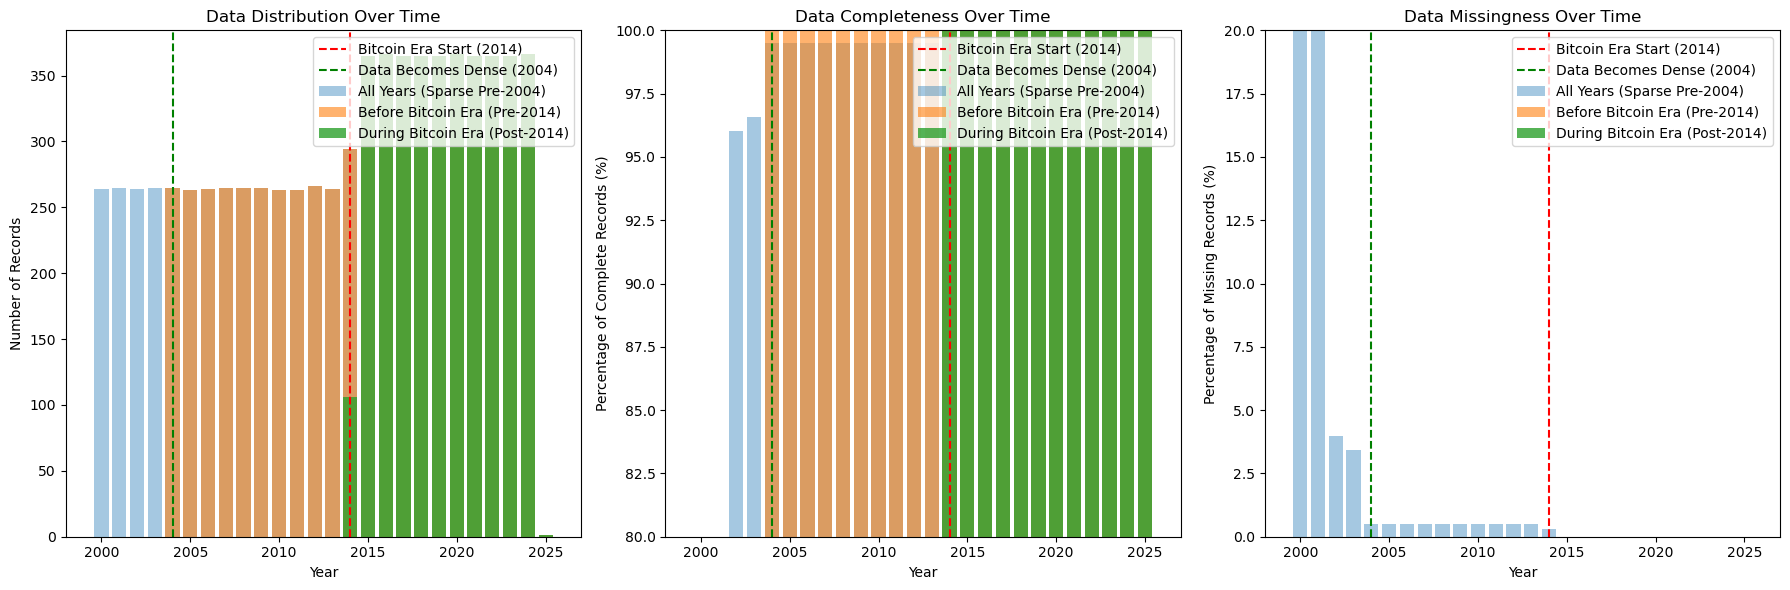

In [11]:
# Load datasets
df0 = dfs["financial_data_all_years"].copy()
df1 = dfs["financial_data"].copy()
df2 = dfs["financial_data_btc_era"].copy()

# Rename the first unnamed column in df0 to 'Date' if it has no name
if df0.columns[0] == "Unnamed: 0":
    df0.rename(columns={df0.columns[0]: "Date"}, inplace=True)

# Convert Date column to datetime format and extract Year
for df in [df0, df1, df2]:
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year

# Function to calculate the percentage of complete (non-null) records per year
def percent_complete(df):
    return df.drop(columns=["Year"]).groupby(df["Year"]).apply(lambda x: x.notnull().mean().mean() * 100)

# Function to calculate the percentage of missing (null) records per year
def percent_missing(df):
    return df.drop(columns=["Year"]).groupby(df["Year"]).apply(lambda x: (1 - x.notnull().mean().mean()) * 100)

# Calculate records per year
df0_counts = df0.groupby('Year').size()
df1_counts = df1.groupby('Year').size()
df2_counts = df2.groupby('Year').size()

# Calculate completeness & missingness
df0_complete = percent_complete(df0)
df1_complete = percent_complete(df1)
df2_complete = percent_complete(df2)

df0_missing = percent_missing(df0)
df1_missing = percent_missing(df1)
df2_missing = percent_missing(df2)

# Find the latest year in the dataset for dynamic x-axis extension
latest_year = max(df0_complete.index.max(), df1_complete.index.max(), df2_complete.index.max())

# Create a single visualization with multiple subplots in a **1-row, 3-column** grid layout
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# Plot number of records per year
axes[0].bar(df0_counts.index, df0_counts.values, alpha=0.4, label="All Years (Sparse Pre-2004)")
axes[0].bar(df1_counts.index, df1_counts.values, alpha=0.6, label="Before Bitcoin Era (Pre-2014)")
axes[0].bar(df2_counts.index, df2_counts.values, alpha=0.8, label="During Bitcoin Era (Post-2014)")
axes[0].axvline(x=2014, color='red', linestyle='--', label="Bitcoin Era Start (2014)")
axes[0].axvline(x=2004, color='green', linestyle='--', label="Data Becomes Dense (2004)")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Number of Records")
axes[0].set_title("Data Distribution Over Time")
axes[0].legend(loc='upper right')

# Plot completeness over time
axes[1].bar(df0_complete.index, df0_complete.values, alpha=0.4, label="All Years (Sparse Pre-2004)")
axes[1].bar(df1_complete.index, df1_complete.values, alpha=0.6, label="Before Bitcoin Era (Pre-2014)")
axes[1].bar(df2_complete.index, df2_complete.values, alpha=0.8, label="During Bitcoin Era (Post-2014)")
axes[1].axvline(x=2014, color='red', linestyle='--', label="Bitcoin Era Start (2014)")
axes[1].axvline(x=2004, color='green', linestyle='--', label="Data Becomes Dense (2004)")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Percentage of Complete Records (%)")
axes[1].set_title("Data Completeness Over Time")
axes[1].set_ylim(80, 100)  # Focus on variations near completeness
axes[1].legend(loc='upper right')

# Plot missingness over time
axes[2].bar(df0_missing.index, df0_missing.values, alpha=0.4, label="All Years (Sparse Pre-2004)")
axes[2].bar(df1_missing.index, df1_missing.values, alpha=0.6, label="Before Bitcoin Era (Pre-2014)")
axes[2].bar(df2_missing.index, df2_missing.values, alpha=0.8, label="During Bitcoin Era (Post-2014)")
axes[2].axvline(x=2014, color='red', linestyle='--', label="Bitcoin Era Start (2014)")
axes[2].axvline(x=2004, color='green', linestyle='--', label="Data Becomes Dense (2004)")
axes[2].set_xlabel("Year")
axes[2].set_ylabel("Percentage of Missing Records (%)")
axes[2].set_title("Data Missingness Over Time")
axes[2].set_ylim(0, 20)  # Focus on variations in missingness
axes[2].legend(loc='upper right')

# ✅ Extend x-axis across all subplots to start before 2000
for ax in axes:
    ax.set_xlim(1998, latest_year + 2)

plt.tight_layout()
plt.show()

#### **2. Feature Engineering**  
- **Lagged Variables**  
  - Key indicators (e.g., interest rates, consumer sentiment, GDP) were **lagged at 30-day, 90-day, and 180-day intervals** to capture delayed market reactions.  
- **Rolling Averages & Volatility Measures**  
  - **90-day and 180-day rolling averages** smooth fluctuations in economic indicators.  
  - **30-day rolling standard deviations** track volatility trends in stock indices and macroeconomic conditions.  
- **Market Event Flags**  
  - Binary markers for **market crashes, recessions, inflation spikes, and stock crashes** were introduced to flag high-impact economic periods.

In [14]:
df = df1.copy()

# Identify the start date of the Bitcoin era in df2
btc_era_start = df2['Date'].min()

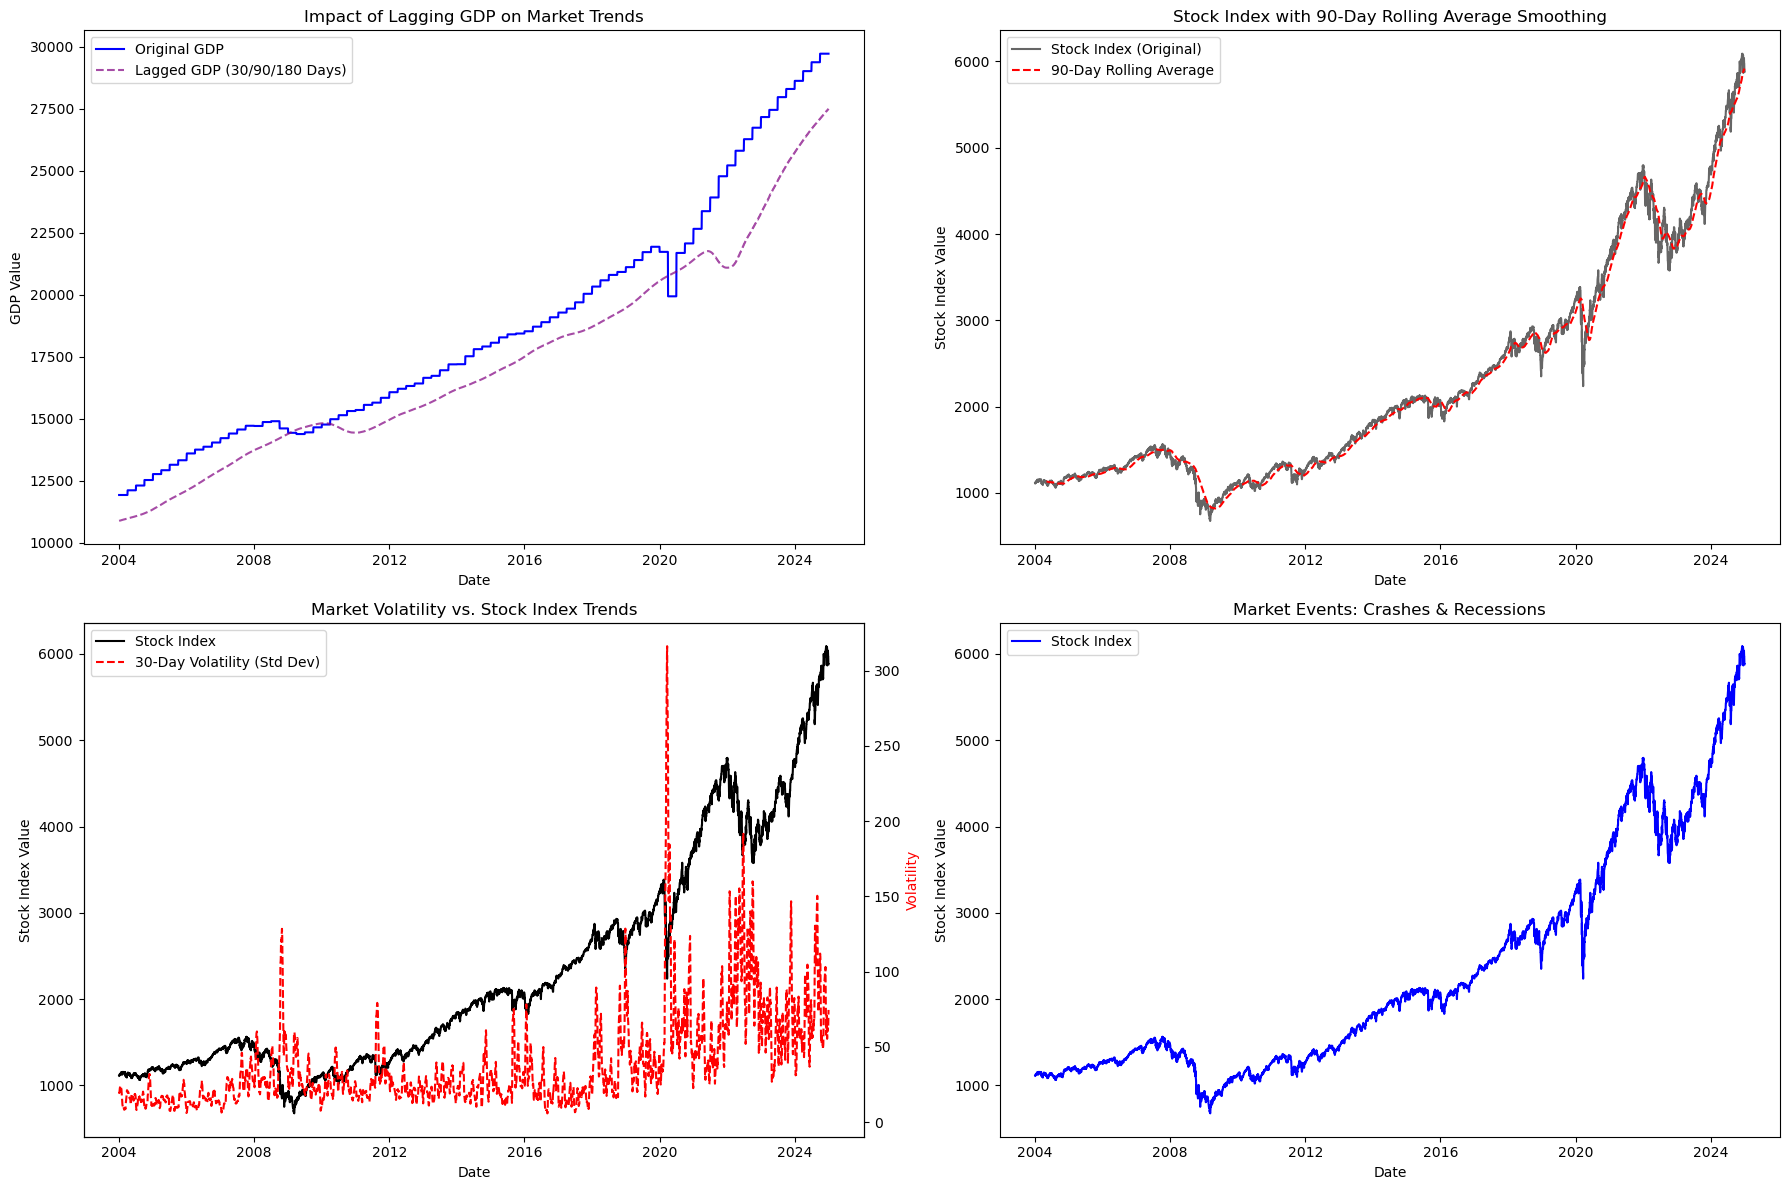

In [16]:
# Create a multi-panel visualization with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1️⃣ Plot Lagged Variables (GDP)
axes[0, 0].plot(df['Date'], df['GDP'], label="Original GDP", color='blue')
axes[0, 0].plot(df['Date'], df['GDP_lag30_lag90_lag180_rolling90_rolling180'], 
                label="Lagged GDP (30/90/180 Days)", linestyle='dashed', color='purple', alpha=0.7)
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("GDP Value")
axes[0, 0].set_title("Impact of Lagging GDP on Market Trends")
axes[0, 0].legend()

# ✅ **Fix 1: Rolling Averages (Stock Index) - Make Rolling Averages Clear**
axes[0, 1].plot(df['Date'], df['Adj Close_^GSPC'], label="Stock Index (Original)", color='black', alpha=0.6)
axes[0, 1].plot(df['Date'], df['Adj Close_^GSPC'].rolling(90).mean(), 
                label="90-Day Rolling Average", linestyle='dashed', color='red')
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Stock Index Value")
axes[0, 1].set_title("Stock Index with 90-Day Rolling Average Smoothing")
axes[0, 1].legend()

# ✅ **Fix 2: Market Volatility vs. Stock Index - Single Legend & Readable Y-Axis**
ax1 = axes[1, 0]
ax2 = ax1.twinx()

# Plot stock index (left y-axis)
ax1.plot(df['Date'], df['Adj Close_^GSPC'], label="Stock Index", color='black')
ax1.set_ylabel("Stock Index Value", color='black')

# Plot rolling standard deviation (volatility, right y-axis)
ax2.plot(df['Date'], df['Rolling_Std_30d'], label="30-Day Volatility (Std Dev)", color='red', linestyle='dashed')
ax2.set_ylabel("Volatility", color='red')

# Merge legends into one
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

ax1.set_xlabel("Date")
ax1.set_title("Market Volatility vs. Stock Index Trends")

# ✅ **Fix 3: Market Events Chart (Cleaner Event Markers)**
axes[1, 1].plot(df['Date'], df['Adj Close_^GSPC'], label="Stock Index", color='blue')

# Plot market crash markers as vertical red lines
for index, row in df.iterrows():
    if row['market crash'] == 1:
        axes[1, 1].axvline(x=row['Date'], color='red', linestyle='--', alpha=0.5)

axes[1, 1].set_xlabel("Date")
axes[1, 1].set_ylabel("Stock Index Value")
axes[1, 1].set_title("Market Events: Crashes & Recessions")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

#### **3. Sentiment & Behavioral Indicators**  
- **Google Trends Data**: Captures search volume for terms like *"market crash,"* *"buy gold,"* and *"interest rates"* to gauge public sentiment shifts.  
- **Interest Rate & Inflation Expectations**: Derived from historical Fed policy changes to approximate market expectations and reactions.  

*Note: Downstream, it would be interesting to isolate the impact of Bitcoin and crypto-related financial activity from **2014 onward** (`financial_data_btc_era`). Comparing trends across both datasets could help assess how **Bitcoin's emergence influenced macroeconomic factors, investor sentiment, and volatility patterns**.*

---

In [25]:
# Compute rolling z-scores to detect anomalies
def rolling_zscore(series, window=90):
    """Calculate rolling z-score to detect anomalies in trends."""
    rolling_mean = series.rolling(window=window, min_periods=1).mean()
    rolling_std = series.rolling(window=window, min_periods=1).std()
    return (series - rolling_mean) / rolling_std

# Apply z-score transformation
df['inflation_z'] = rolling_zscore(df['inflation'])
df['interest_rate_z'] = rolling_zscore(df['Interest Rate'])
df['search_interest_z'] = rolling_zscore(df['interest rates'])

# Identify stress & relief periods
df['spike'] = (df['inflation_z'] > 1) & (df['interest_rate_z'] > 1) & (df['search_interest_z'] > 1)
df['relief_intensity'] = -df[['inflation_z', 'interest_rate_z', 'search_interest_z']].mean(axis=1)

# Ensure stress and relief indicators are numerically stable
df['stress_alpha'] = np.where(df['spike'], 0.3, 0)  # Fixed intensity for stress (binary)
df['relief_alpha'] = df['relief_intensity'].clip(0.1, 0.6)  # Normalize relief shading intensity

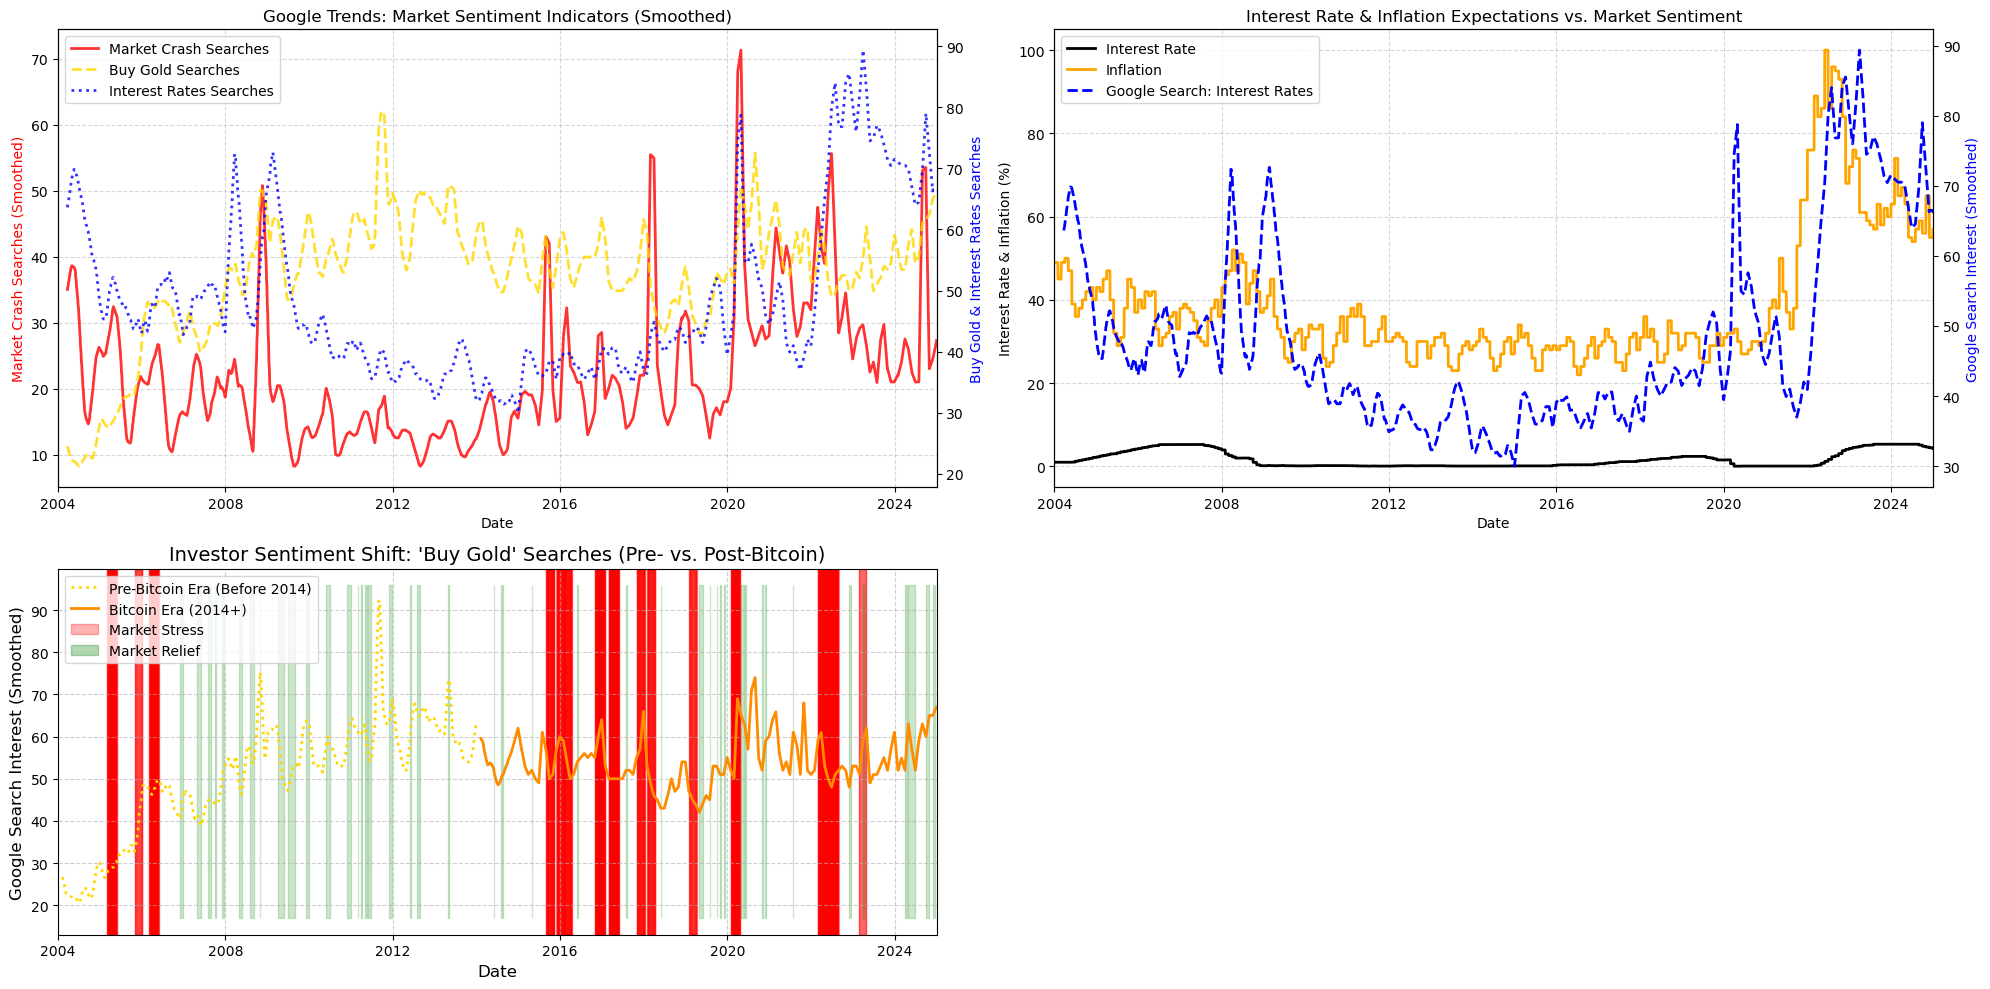

In [35]:
# Create a multi-panel visualization with 1st row (2 side-by-side) & 2nd row (full width)
fig, axes = plt.subplots(2, 2, figsize=(20, 10), gridspec_kw={'height_ratios': [1, 0.8]})

### 1️⃣ Google Trends Search Volume Over Time (Smoothed & Improved Layout)
ax1 = axes[0, 0]
ax2 = ax1.twinx()  # Secondary y-axis

# Use 60-day rolling average for smoothing
line1, = ax1.plot(df['Date'], df['market crash'].rolling(60).mean(), 
                   label="Market Crash Searches", color='red', alpha=0.8, linewidth=2, linestyle='-')
line2, = ax2.plot(df['Date'], df['buy gold'].rolling(60).mean(), 
                   label="Buy Gold Searches", color='gold', alpha=0.8, linewidth=2, linestyle='dashed')
line3, = ax2.plot(df['Date'], df['interest rates'].rolling(60).mean(), 
                   label="Interest Rates Searches", color='blue', alpha=0.8, linewidth=2, linestyle='dotted')

ax1.set_xlabel("Date")
ax1.set_ylabel("Market Crash Searches (Smoothed)", color='red')
ax2.set_ylabel("Buy Gold & Interest Rates Searches", color='blue')

ax1.set_title("Google Trends: Market Sentiment Indicators (Smoothed)")
ax1.grid(True, linestyle="--", alpha=0.5)

# ✅ Unified legend placement (Upper Left)
handles = [line1, line2, line3]
labels = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc="upper left", frameon=True)

### 2️⃣ Interest Rate & Inflation Expectations vs. Market Sentiment (Unified Legend)
ax3 = axes[0, 1]
ax4 = ax3.twinx()

ax3.plot(df['Date'], df['Interest Rate'], label="Interest Rate", color='black', linewidth=2)
ax3.plot(df['Date'], df['inflation'], label="Inflation", color='orange', linewidth=2)
ax4.plot(df['Date'], df['interest rates'].rolling(60).mean(), 
         label="Google Search: Interest Rates", color='blue', linestyle='dashed', linewidth=2)

ax3.set_xlabel("Date")
ax3.set_ylabel("Interest Rate & Inflation (%)", color='black')
ax4.set_ylabel("Google Search Interest (Smoothed)", color='blue')

ax3.set_title("Interest Rate & Inflation Expectations vs. Market Sentiment")
ax3.grid(True, linestyle="--", alpha=0.5)

# ✅ Unified legend placement (Upper Left)
handles1, labels1 = ax3.get_legend_handles_labels()
handles2, labels2 = ax4.get_legend_handles_labels()
ax3.legend(handles1 + handles2, labels1 + labels2, loc="upper left", frameon=True)

# ✅ Extend x-axis for better spacing across first two plots
for ax in [ax1, ax3]:
    ax.set_xlim(df['Date'].min(), df['Date'].max())

# ⚡️ 3️⃣ Bitcoin Era Sentiment Shift (Full-Width, Bottom Row)
ax_btc = axes[1, 0]

# Ensure pre-2014 data exists
pre_btc = df[df['Date'] < '2014-01-01']
post_btc = df[df['Date'] >= '2014-01-01']

# 📈 Plot Search Trends for 'Buy Gold'
ax_btc.plot(pre_btc['Date'], pre_btc['buy gold'].rolling(30).mean(), 
         label="Pre-Bitcoin Era (Before 2014)", color='gold', linestyle='dotted', linewidth=2)

ax_btc.plot(post_btc['Date'], post_btc['buy gold'].rolling(30).mean(), 
         label="Bitcoin Era (2014+)", color='darkorange', linewidth=2)

# 🔴 **Overlay Market Stress Shading**
for _, row in df[df['spike']].iterrows():
    ax_btc.axvspan(row['Date'], row['Date'] + pd.Timedelta(days=60), color='red', alpha=0.2)

# 🟢 **Overlay Market Relief Shading**
ax_btc.fill_between(df['Date'], ax_btc.get_ylim()[0], ax_btc.get_ylim()[1], 
                 where=df['relief_intensity'] > 1, color='green', alpha=0.2)

# 📌 Labels and Titles
ax_btc.set_xlabel("Date", fontsize=12)
ax_btc.set_ylabel("Google Search Interest (Smoothed)", fontsize=12, color='black')
ax_btc.set_title("Investor Sentiment Shift: 'Buy Gold' Searches (Pre- vs. Post-Bitcoin)", fontsize=14)

# 🏷️ Improved Legend (Upper Left)
red_patch = mpatches.Patch(color='red', alpha=0.3, label="Market Stress Periods")
green_patch = mpatches.Patch(color='green', alpha=0.3, label="Market Relief Periods")

handles_btc, labels_btc = ax_btc.get_legend_handles_labels()

ax_btc.legend(handles_btc + [red_patch, green_patch], 
              labels_btc + ["Market Stress", "Market Relief"], 
              loc="upper left", frameon=True)

# ✅ Extend x-axis for better spacing across all plots
for ax in [ax1, ax3, ax_btc]:
    ax.set_xlim(df['Date'].min(), df['Date'].max())

# ✅ Remove empty subplot (second column in row 2)
fig.delaxes(axes[1, 1])

# 📊 Improve Grid Visibility
ax_btc.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

## **III. Key Economic Patterns and Market Trends**

#### **1. Market Volatility and Crash Indicators**

(What should go here: Discuss trends in stock indices such as S&P 500, NASDAQ, and VIX. How do these relate to economic downturns, crashes, or recessions? Highlight key observations from the dataset.)

#### **2. Interest Rates, Inflation, and Economic Cycles**

(What should go here: Explore how interest rates, inflation, and consumer sentiment correlate with economic growth or stagnation. Identify periods of high inflation or aggressive rate hikes and their impact on markets.)

#### **3. Unemployment and Recessionary Signals**

(What should go here: Analyze unemployment trends alongside GDP, consumer sentiment, and bond yields. How do these factors signal impending recessions or economic recoveries?)

#### **4. Gold as a Safe Haven Asset**

(What should go here: Examine the relationship between economic downturns and gold investments. Does the data support the idea that investors move toward gold during market uncertainty?)

---

## **IV. The Role of Lagged and Rolling Features in Forecasting**

(What should go here: Explain the use of lagged and rolling features in the dataset. How do these help in identifying economic patterns or predicting financial trends? Showcase any meaningful insights derived from these features.)

---

## **V. Predictive Modeling and Insights**

(What should go here: If applicable, discuss initial predictive modeling efforts, such as using ARIMA, LSTMs, or other statistical/machine learning methods. Highlight any challenges or preliminary findings.)

⸻

## **VI. Conclusion: Mapping Economic Complexity**

(What should go here: Summarize key takeaways from the analysis. How does this dataset enhance our understanding of financial markets and economic cycles? Discuss any potential next steps for deeper analysis or applications.)

⸻